# CS-E4600 — Programming project

## Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from scipy.cluster.vq import vq, kmeans, whiten

## Read file

In [27]:
#file = 'test'
file = 'ca-GrQc'
#file = 'Oregon-1'

## Read First line info and Edges

In [28]:
folder = './graphs_processed/'
with open(folder + file + '.txt') as f:
    first_line = f.readline()
first_line = first_line.split()

num_nodes = int(first_line[2])
num_edges = int(first_line[3])
k = int(first_line[4])
print(num_nodes, num_edges, k)

    
pd_edges = pd.read_csv(folder + file + '.txt', sep=" ", skiprows=range(0, 1), header=None)
pd_edges.columns = ["FromNodeId","ToNodeId"]
#pd_edges

4158 13428 2


## Select Distinct Nodes

In [29]:
node_candidates_1 = pd_edges.drop_duplicates(subset="FromNodeId")["FromNodeId"]
node_candidates_2 = pd_edges.drop_duplicates(subset="ToNodeId")["ToNodeId"]

In [30]:
pd_nodes = pd.concat([node_candidates_1, node_candidates_2])
pd_nodes = pd_nodes.drop_duplicates()
#pd_nodes

## Convert Nodes and Edges to Numpy

In [31]:
nodes = pd_nodes.values
edges = pd_edges.values
nodes2 = np.arange(num_nodes)
#print(nodes.shape, nodes.shape)
print(nodes)
print(nodes2)
nodes = nodes2
#nodes.shape, edges.shape

[   0    1    2 ... 3971 4095 4138]
[   0    1    2 ... 4155 4156 4157]


## Create Adjacency Matrix

what to do with too big arrays??

In [32]:
adjacency_matrix = np.zeros((nodes.size, nodes.size))
#adjacency_matrix.shape

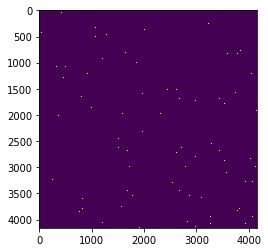

In [33]:
for i in range(0,edges.shape[0]):
    adjacency_matrix[edges[i,0], edges[i,1]] = 1
    adjacency_matrix[edges[i,1], edges[i,0]] = 1
#np.sum(adjacency_matrix)
plt.imshow(adjacency_matrix)

## Create Laplacian Matrix

In [34]:
laplacian = csgraph.laplacian(adjacency_matrix, normed=True)
np.sum(laplacian)

656.1491255509026

## Alternative way for the Laplacian Matrix

In [193]:
degrees = np.sum(adjacency_matrix, axis=0)
L_normed = np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L_normed[i,j] = -1.0/(np.sqrt(degrees[i]*degrees[j]))

In [194]:
degrees = np.sum(adjacency_matrix, axis=0)
L = degrees * np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L[i,j] = -1

In [195]:
np.sum(L_normed)

657.0976242600357

## Eigen-decomposition

In [196]:
_w, _v = np.linalg.eig(L_normed)

In [35]:
w, v = eigsh(laplacian, k, which="SA")
print(v)

[[0.00610346 0.0009242 ]
 [0.01220693 0.00347964]
 [0.01220693 0.00196978]
 ...
 [0.00610346 0.00146128]
 [0.0172632  0.00271272]
 [0.0086316  0.00168531]]


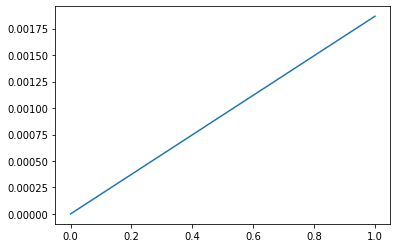

In [36]:
plt.plot(w)
plt.show()

## Selects second smallest eigenvalue and corresponding eigenvector

In [37]:
eig_val_idx = np.argpartition(w,k-1)[1]
eig_val_idx
eig_vec = v[:,eig_val_idx]

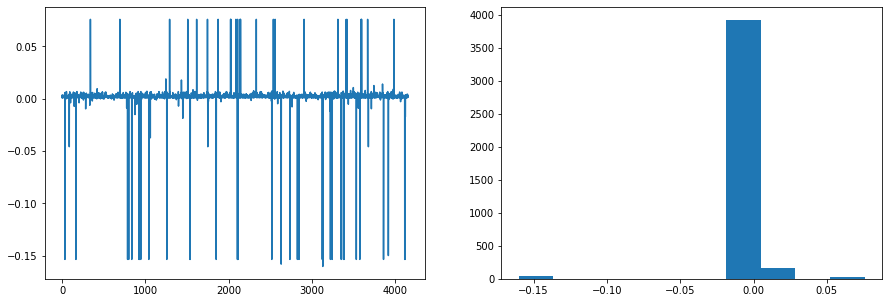

In [38]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(eig_vec)
plt.subplot(1, 2, 2)
plt.hist(eig_vec)
plt.show()

## K-means clustering

Should be improved to enforce balanced cluster sizes

In [39]:
whitened = whiten(v)
k_means, distortion = kmeans(v,k)
print(k_means)

[[9.86045067e-03 1.42100274e-03]
 [2.34473598e-02 9.21011123e-05]]


## Select cluster for all vertices

In [40]:
def cluster(node, k_means):
    node_cluster = 0
    node_distance = np.linalg.norm(node - k_means[0,:])
    
    for i in range(1,k_means.shape[0]):
        tmp_distance = np.linalg.norm(node - k_means[i,:])
        if (tmp_distance < node_distance):
            node_distance = tmp_distance
            node_cluster = i
                
    return node_cluster
        

In [41]:
clusters = np.zeros((num_nodes,1))
for j in range(clusters.size):
    clusters[j] = cluster(v[j,:], k_means)

In [42]:
unique, counts = np.unique(clusters, return_counts=True)

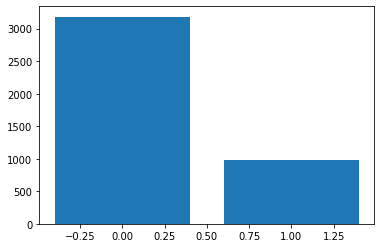

In [43]:
bars = np.arange(k)
plt.bar(bars, counts)
plt.show()

## Calculate cost for clusters

In [44]:
outer_edges = np.zeros((k,1))

for i in range(k):
    for j in range(num_edges):
        if(((clusters[edges[j,0]] == i) and (clusters[edges[j,1]] != i))
        or ((clusters[edges[j,0]] != i) and (clusters[edges[j,1]] == i))):
            outer_edges[i] += 1

In [45]:
counts = counts.reshape(k,-1)
costs = outer_edges / counts
cost = sum(costs)
print(outer_edges,"\n\n" ,  costs,"\n\n", cost)            

[[4367.]
 [4367.]] 

 [[1.37197612]
 [4.47897436]] 

 [5.85095048]


In [46]:
all_edges = np.zeros((k,1))

for i in range(k):
    for j in range(num_edges):
        if((clusters[edges[j,0]] == i) or (clusters[edges[j,1]] == i)):
            all_edges[i] +=1
print(all_edges)

[[ 6973.]
 [10822.]]


## Output clusters

In [49]:
out_file = open("./results/" + file + ".output" + ".txt", "w")
for i in range (num_nodes):
    out_file.write(str(i) + " " + str(int(clusters[i,0])) + "\n")
out_file.close()